<a href="https://colab.research.google.com/github/NelsenTimoty/colab_projects/blob/main/resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Memuat dan memproses data
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Memuat dataset CIFAR-10
train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True, num_workers=2)

val_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=128, shuffle=False, num_workers=2)

# 2. Mendefinisikan model ResNet18
# Memuat model ResNet18 tanpa bobot pretrained (atur pretrained=True untuk bobot ImageNet)
model = models.resnet18(pretrained=False)

# Memodifikasi lapisan convolution pertama untuk ukuran input CIFAR-10 (32x32)
model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)

# Menghapus lapisan maxpool untuk menyesuaikan ukuran input yang lebih kecil dari CIFAR-10
model.maxpool = nn.Identity()

# Memodifikasi lapisan fully connected (fc) untuk menghasilkan 10 kelas (CIFAR-10 memiliki 10 kelas)
model.fc = nn.Linear(512, 10)

# Pindahkan model ke GPU jika tersedia
model = model.to(device)

# Definisikan fungsi loss (cross-entropy untuk klasifikasi multi-kelas)
# Definisikan optimizer (Adam dengan learning rate 0.001)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Fungsi untuk melatih dan memvalidasi model selama beberapa epoch
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    best_accuracy = 0.0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_predictions = 0
        total_predictions = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_predictions += (preds == labels).sum().item()
            total_predictions += labels.size(0)

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = correct_predictions / total_predictions

        # Fase validasi: evaluasi model pada set validasi
        model.eval()
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        val_acc = val_correct / val_total
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_acc:.4f}, Val Accuracy: {val_acc:.4f}')

        if val_acc > best_accuracy:
            best_accuracy = val_acc
            torch.save(model.state_dict(), 'best_resnet18_model.pth')

    print(f'Best Validation Accuracy: {best_accuracy:.4f}')
    return model

# 5. Melatih model
trained_model = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10)

Output pakai Vscode

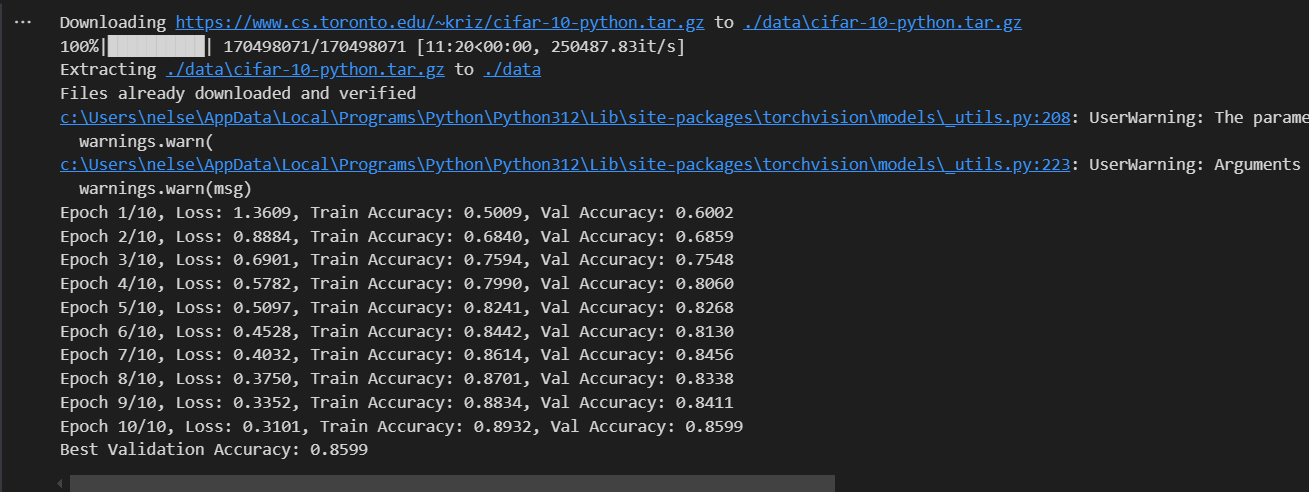